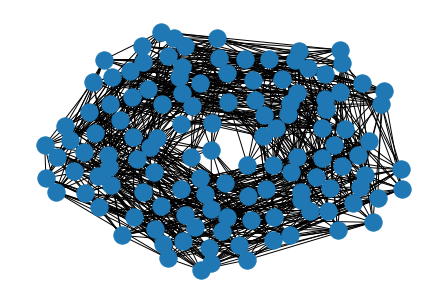

In [1]:
# Create a graph and visualize it
import networkx as nx
G = nx.read_edgelist("5x5x5-extra-mirror.txt")
nx.draw(G)

In [2]:
initial_colors = nx.greedy_color(G,strategy='smallest_last')
print("initial_colors =",initial_colors)

initial_colors = {'98': 0, '73': 1, '99': 1, '74': 0, '68': 0, '69': 1, '93': 1, '94': 0, '88': 0, '63': 1, '78': 1, '79': 0, '53': 0, '84': 2, '89': 1, '54': 1, '83': 3, '64': 0, '58': 2, '59': 3, '43': 1, '44': 0, '48': 0, '49': 1, '38': 0, '118': 0, '119': 1, '19': 2, '113': 1, '114': 0, '18': 3, '39': 1, '123': 1, '124': 0, '23': 2, '24': 3, '13': 2, '14': 3, '34': 4, '29': 0, '28': 1, '9': 2, '103': 0, '109': 3, '104': 1, '3': 5, '4': 4, '33': 5, '108': 2, '8': 3, '100': 2, '0': 0, '120': 4, '20': 1, '25': 1, '45': 0, '50': 0, '75': 1, '95': 0, '70': 1, '22': 3, '17': 2, '117': 1, '122': 0, '2': 4, '102': 1, '27': 0, '47': 1, '21': 4, '121': 3, '46': 3, '52': 1, '77': 0, '97': 1, '96': 4, '72': 0, '101': 4, '1': 2, '71': 2, '76': 2, '26': 4, '51': 3, '42': 0, '105': 3, '5': 2, '30': 4, '15': 0, '115': 3, '107': 3, '7': 2, '10': 1, '116': 2, '106': 2, '12': 3, '11': 2, '16': 3, '6': 3, '110': 2, '112': 0, '111': 1, '92': 0, '32': 4, '37': 1, '82': 2, '31': 2, '80': 2, '55': 5, '87'

In [3]:
colors_used = { initial_colors[i] for i in G.nodes }
print("colors_used =",colors_used)

colors_used = {0, 1, 2, 3, 4, 5}


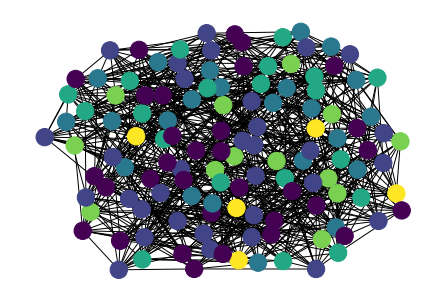

In [4]:
node_colors = [ initial_colors[i] for i in G.nodes ]
nx.draw( G, node_color=node_colors )

In [5]:
import gurobipy as gp
from gurobipy import GRB

In [6]:
def maximum_weight_independent_set( G, weight=None, forced_nodes=list(), verbose=False ):

    if weight is None:
        weight = { i : 1 for i in G.nodes }
        
    m = gp.Model()
    if not verbose:
        m.Params.OutputFlag = 0
    
    # x[i]=1 if pick vertex i
    x = m.addVars( G.nodes, vtype=GRB.BINARY )
    
    # can pick at most one endpoint of each edge {i,j}
    m.addConstrs( x[i] + x[j] <= 1 for i,j in G.edges )
    
    # each node in forced_nodes must be selected in our independent set
    for i in forced_nodes:
        x[i].LB = 1
        
    # maximize weight of independent set
    m.setObjective( gp.quicksum( weight[i] * x[i] for i in G.nodes ), GRB.MAXIMIZE )
    m.optimize()
    
    assert m.solCount > 0
    independent_set = [ i for i in G.nodes if x[i].x > 0.5 ]
    
    return (independent_set, m.objVal)

In [7]:
(ind_set, size) = maximum_weight_independent_set(G)
print("Here is a maximum (cardinality) independent set =",ind_set)
print("Its size is =",size)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-01-01
Here is a maximum (cardinality) independent set = ['0', '2', '6', '21', '26', '30', '32', '45', '47', '101', '105', '107', '120', '122', '4', '8', '23', '28', '34', '49', '103', '109', '124', '10', '14', '36', '79', '89', '111', '12', '38', '113', '75', '85', '81', '96', '77', '83', '98', '87']
Its size is = 40.0


In [8]:
def fractional_chromatic_number( G ):
    
    # Get an initial coloring, somehow
    initial_colors = nx.greedy_color(G,strategy='smallest_last')
    colors_used = { initial_colors[i] for i in G.nodes }
    ind_sets = [ [ i for i in G.nodes if initial_colors[i] == color ] for color in colors_used ]
    num_ind_sets = len(ind_sets)

    print("Intializing model with these independent sets (or columns):")
    for j in range(num_ind_sets):
        # ... a trick to make them (inclusion-wise) maximal
        (ind_sets[j], ignore_this_weight) = maximum_weight_independent_set(G, forced_nodes=ind_sets[j])
        print(j,':',ind_sets[j])
    print("")
    
    m = gp.Model()
    m.Params.OutputFlag = 0
    
    # Idea: x[j]=1 if we use the j-th independent set
    #       However, we are solving the LP relaxation ("fractional chromatic number")
    #       So, we let x[j] be continuous!
    x = m.addVars( num_ind_sets, vtype=GRB.CONTINUOUS )
    
    # Cover constraints (cc): each vertex should be covered *at least* once
    cc = m.addConstrs( gp.quicksum( x[j] for j in range(num_ind_sets) if i in ind_sets[j] ) >= 1 for i in G.nodes )
    
    # Objective: minimize the number of ind sets used
    m.setObjective( gp.quicksum(x), GRB.MINIMIZE )
    
    print("Applying column generation algorithm")
    print("iter \t obj \t mwis \t reduced_cost")
    epsilon = 0.00001
    max_iterations = 1000
    
    for iteration in range(max_iterations):

        # Solve the set cover linear program
        m.optimize()

        # Get values of dual variables
        dual_vals = { i : cc[i].Pi for i in G.nodes }
        #print(dual_vals)

        # Find a maximum weight independent set, where vertex i has weight dual_vals[i]
        (mwis, mwis_weight) = maximum_weight_independent_set(G, weight=dual_vals)

        reduced_cost = 1 - mwis_weight
        print(iteration,'\t','{0:.2f}'.format(m.objVal),'\t','{0:.2f}'.format(mwis_weight),'\t','{0:.2f}'.format(reduced_cost))

        # Exit if all reduced costs are positive
        if reduced_cost > -epsilon:
            break
        
        # ... a trick to make our independent set (inclusion-wise) maximal
        (mwis, ignore_this_weight) = maximum_weight_independent_set(G, forced_nodes=mwis)

        # Add a variable to our problem for our new (maximal) independent set
        #   whose coefficient in the objective function is 1
        x[num_ind_sets] = m.addVar(obj=1)
        
        # Add this variable to relevant constraints
        for i in mwis:
            m.chgCoeff( cc[i], x[num_ind_sets], 1)
            
        ind_sets.append(mwis)
        num_ind_sets += 1
      
    soln = { j : x[j].x for j in range(num_ind_sets) }
    
    print("\nFractional chromatic number =",'{0:.4f}'.format(m.objVal),"using:")
    for j in range(len(ind_sets)):
        ind_set = ind_sets[j]
        if soln[j] > epsilon:
            print('{0:.4f}'.format(soln[j]),'= x(',ind_set,')')
    
    return (ind_sets, soln, m.objVal)

In [9]:
(ind_sets, soln, obj) = fractional_chromatic_number(G)

Intializing model with these independent sets (or columns):
0 : ['0', '45', '122', '27', '48', '103', '124', '29', '95', '79', '35', '112', '38', '114', '85', '15', '94', '42', '118', '44', '50', '74', '72', '53', '64', '62', '65', '68', '77', '98', '88', '92']
1 : ['20', '25', '99', '104', '47', '102', '123', '28', '49', '10', '89', '111', '37', '113', '39', '75', '40', '117', '43', '119', '70', '52', '73', '54', '60', '63', '69', '67', '97', '78', '87', '93']
2 : ['1', '5', '9', '31', '84', '100', '106', '7', '108', '23', '80', '11', '35', '110', '112', '13', '114', '15', '19', '41', '94', '116', '17', '118', '71', '74', '58', '68', '76', '82', '98', '86', '88']
3 : ['20', '24', '46', '99', '121', '6', '105', '107', '22', '123', '8', '109', '10', '14', '89', '111', '12', '113', '16', '40', '115', '117', '18', '119', '59', '51', '57', '70', '73', '63', '66', '69', '81', '83', '93']
4 : ['0', '2', '6', '21', '26', '30', '32', '45', '47', '101', '105', '107', '120', '122', '4', '8', '23

265 	 3.76 	 1.18 	 -0.18
266 	 3.76 	 1.16 	 -0.16
267 	 3.76 	 1.18 	 -0.18
268 	 3.76 	 1.17 	 -0.17
269 	 3.76 	 1.19 	 -0.19
270 	 3.76 	 1.16 	 -0.16
271 	 3.75 	 1.18 	 -0.18
272 	 3.75 	 1.20 	 -0.20
273 	 3.75 	 1.17 	 -0.17
274 	 3.75 	 1.19 	 -0.19
275 	 3.75 	 1.20 	 -0.20
276 	 3.74 	 1.19 	 -0.19
277 	 3.74 	 1.17 	 -0.17
278 	 3.74 	 1.18 	 -0.18
279 	 3.74 	 1.19 	 -0.19
280 	 3.74 	 1.19 	 -0.19
281 	 3.74 	 1.18 	 -0.18
282 	 3.74 	 1.17 	 -0.17
283 	 3.74 	 1.17 	 -0.17
284 	 3.74 	 1.17 	 -0.17
285 	 3.74 	 1.17 	 -0.17
286 	 3.74 	 1.17 	 -0.17
287 	 3.74 	 1.16 	 -0.16
288 	 3.73 	 1.17 	 -0.17
289 	 3.73 	 1.20 	 -0.20
290 	 3.73 	 1.22 	 -0.22
291 	 3.73 	 1.16 	 -0.16
292 	 3.73 	 1.17 	 -0.17
293 	 3.73 	 1.19 	 -0.19
294 	 3.73 	 1.17 	 -0.17
295 	 3.73 	 1.17 	 -0.17
296 	 3.73 	 1.18 	 -0.18
297 	 3.73 	 1.21 	 -0.21
298 	 3.72 	 1.18 	 -0.18
299 	 3.72 	 1.17 	 -0.17
300 	 3.72 	 1.15 	 -0.15
301 	 3.72 	 1.16 	 -0.16
302 	 3.72 	 1.15 	 -0.15
303 	 3.72 	

581 	 3.64 	 1.04 	 -0.04
582 	 3.64 	 1.05 	 -0.05
583 	 3.64 	 1.04 	 -0.04
584 	 3.64 	 1.06 	 -0.06
585 	 3.64 	 1.04 	 -0.04
586 	 3.64 	 1.05 	 -0.05
587 	 3.64 	 1.05 	 -0.05
588 	 3.64 	 1.04 	 -0.04
589 	 3.64 	 1.05 	 -0.05
590 	 3.64 	 1.05 	 -0.05
591 	 3.64 	 1.05 	 -0.05
592 	 3.64 	 1.04 	 -0.04
593 	 3.64 	 1.06 	 -0.06
594 	 3.64 	 1.06 	 -0.06
595 	 3.64 	 1.04 	 -0.04
596 	 3.64 	 1.05 	 -0.05
597 	 3.64 	 1.03 	 -0.03
598 	 3.64 	 1.04 	 -0.04
599 	 3.64 	 1.04 	 -0.04
600 	 3.64 	 1.03 	 -0.03
601 	 3.64 	 1.04 	 -0.04
602 	 3.64 	 1.04 	 -0.04
603 	 3.64 	 1.04 	 -0.04
604 	 3.64 	 1.04 	 -0.04
605 	 3.64 	 1.05 	 -0.05
606 	 3.64 	 1.06 	 -0.06
607 	 3.64 	 1.05 	 -0.05
608 	 3.64 	 1.04 	 -0.04
609 	 3.64 	 1.04 	 -0.04
610 	 3.64 	 1.05 	 -0.05
611 	 3.64 	 1.04 	 -0.04
612 	 3.64 	 1.05 	 -0.05
613 	 3.64 	 1.04 	 -0.04
614 	 3.64 	 1.04 	 -0.04
615 	 3.64 	 1.04 	 -0.04
616 	 3.64 	 1.04 	 -0.04
617 	 3.64 	 1.03 	 -0.03
618 	 3.64 	 1.03 	 -0.03
619 	 3.63 	

In [10]:
def graph_coloring_via_set_cover(G, ind_sets):
    
    m = gp.Model()
    
    # create a binary variable for each independent set
    num_ind_sets = len(ind_sets)
    x = m.addVars( num_ind_sets, vtype=GRB.BINARY )
    
    # Cover constraints: each vertex should be covered *at least* once by an independent set
    m.addConstrs( gp.quicksum( x[j] for j in range(num_ind_sets) if i in ind_sets[j] ) >= 1 for i in G.nodes )
    
    # Objective: minimize the number of independent sets used
    m.setObjective( gp.quicksum(x), GRB.MINIMIZE )
    
    # Solve
    m.optimize()
    soln = [ ind_sets[j] for j in range(num_ind_sets) if x[j].x > 0.5 ]
    
    print("Objective value =",round(m.objVal),"using these independent sets:")
    for ind_set in soln:
        print(ind_set)

    return soln

In [11]:
# Solve the IP over the generated columns.
#   **Note: This is only a heuristic. 
#     For an exact solution, we would need to embed column
#     generation in branch-and-bound ("branch-and-price").
int_soln = graph_coloring_via_set_cover(G, ind_sets)

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 125 rows, 714 columns and 22620 nonzeros
Model fingerprint: 0xb152ed91
Variable types: 0 continuous, 714 integer (714 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 7.0000000
Presolve time: 0.03s
Presolved: 125 rows, 714 columns, 22620 nonzeros
Variable types: 0 continuous, 714 integer (714 binary)

Root relaxation: objective 3.625000e+00, 820 iterations, 0.08 seconds (0.09 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    3.62500    0  119    7.00000    3.62500  48.2%     -    0s
H    0     0                       6.0000000    3.62500  39.6%     -    0s